In [1]:
#Añadir la raiz del proyecto temporal
import sys
sys.path.insert(0, "/home/ubuntu/projects/historical-analysis-management-tickets")

In [2]:
#dependencias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
import re
import glob
import os
import nltk
import time
from nltk.corpus import stopwords
import numpy as np
from src.configuraciones import limpiar_texto
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib

In [3]:
#configuracion
plt.style.use('ggplot')

path = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
all_files = glob.glob(os.path.join(path, "df*.csv"))

df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    if 'fecha_de_apertura' in df.columns:
        df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

/tmp/ipykernel_309528/4086124660.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)


In [4]:
#asegurar categoria
if 'area' not in df_all.columns:
    df_all['area'] = df_all['categoria'].fillna('Sin Categoria').apply(lambda x: str(x).split('>')[0].strip())

df_labeled = df_all[df_all['area'] != 'Sin Categoria'].copy()

min_tickets = 20

#contamos clases
conteo_areas = df_labeled['area'].value_counts()
areas_validas = conteo_areas[conteo_areas > 50].index
df_labeled = df_labeled[df_labeled['area'].isin(areas_validas)]

print(f"Entrenando con {len(df_labeled)} tickets.")
print(f"Clases a predecir ({len(areas_validas)}): {list(areas_validas)}")

counts = df_labeled['area'].value_counts()
df_train = df_labeled[df_labeled['area'].isin(counts[counts > min_tickets].index)]

Entrenando con 102576 tickets.
Clases a predecir (22): ['DBA', 'Soporte de Campo', 'Aplicaciones', 'MDA', 'ABM', 'Ingenieros TI', 'OT', 'Técnico TI', 'Telecomunicaciones', 'Folios OT', 'Seguimientos IMA', 'Sistemas GIS', 'AMI', 'SAP', 'DTE', 'Telecomunicaciones Operacionales', 'Actividades Proyectos IMA', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'TDO', 'Ciberseguridad', 'Meridian', 'PowerOn']


In [5]:
#limpieza de texto
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

#data para XGBoost
le = LabelEncoder()
df_labeled['label_code'] = le.fit_transform(df_labeled['area'])
label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("Clases detectadas:", list(label_map.values()))

#limpieza de texto
df_labeled["texto_limpio"] = df_labeled["titulo"].apply(limpiar_texto)

#variables
X = df_labeled['texto_limpio']
#y = df_labeled['area']
y = df_labeled['label_code']

#80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clases detectadas: ['ABM', 'AMI', 'Actividades Proyectos IMA', 'Aplicaciones', 'Ciberseguridad', 'DBA', 'DTE', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'Folios OT', 'Ingenieros TI', 'MDA', 'Meridian', 'OT', 'PowerOn', 'SAP', 'Seguimientos IMA', 'Sistemas GIS', 'Soporte de Campo', 'TDO', 'Telecomunicaciones', 'Telecomunicaciones Operacionales', 'Técnico TI']



 inicio training de modelos
Naive Bayes: Acc=82.92% | F1=81.54% | 0.7s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression: Acc=82.48% | F1=84.44% | 16.9s
SVM (Linear): Acc=86.14% | F1=86.98% | 5.5s
Random Forest: Acc=86.84% | F1=86.84% | 67.2s
XGBoost: Acc=86.37% | F1=86.06% | 61.3s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: Acc=76.55% | F1=77.03% | 32.1s
                Modelo  Accuracy  F1-Score  Tiempo (s)
2         SVM (Linear)  0.861376  0.869824    5.482417
3        Random Forest  0.868444  0.868399   67.239429
4              XGBoost  0.863667  0.860568   61.295824
1  Logistic Regression  0.824820  0.844436   16.941509
0          Naive Bayes  0.829158  0.815397    0.719330
5             LightGBM  0.765451  0.770346   32.108616


/tmp/ipykernel_309528/2878991524.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x='F1-Score', y='Modelo', palette='viridis')


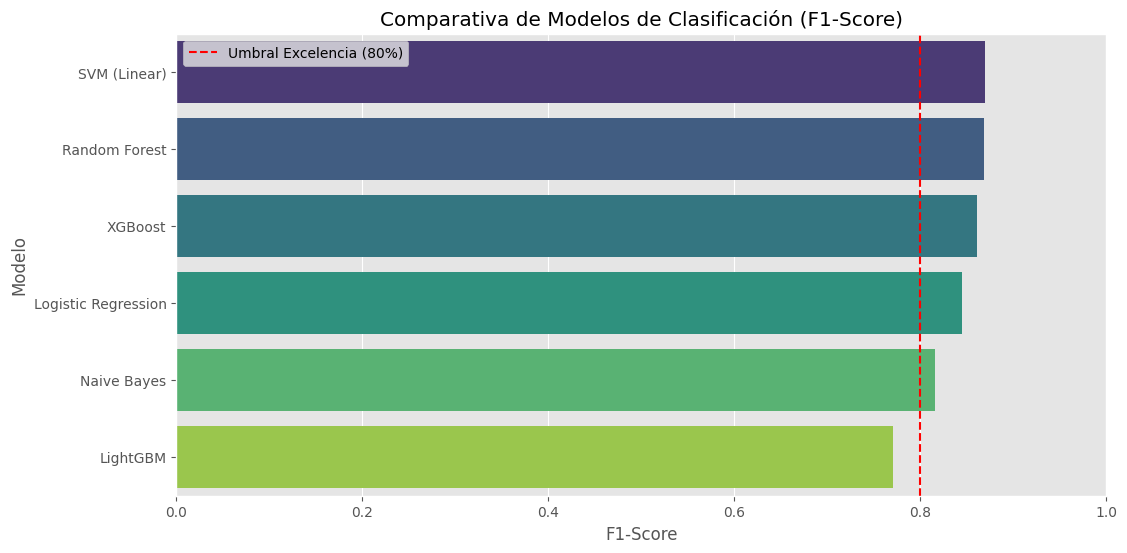


 Analizando a fondo al ganador: SVM (Linear)
                                                 precision    recall  f1-score   support

                                            ABM       0.75      0.79      0.77      1499
                                            AMI       0.60      0.86      0.70        65
                      Actividades Proyectos IMA       0.41      0.61      0.49        36
                                   Aplicaciones       0.90      0.84      0.87      3429
                                 Ciberseguridad       0.19      0.50      0.27        16
                                            DBA       0.97      0.92      0.94      5577
                                            DTE       0.46      0.66      0.54        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.05      0.20      0.08        35
                                      Folios OT       0.99      0.99      0.99       143
                                  Ingenieros TI       0.69     

In [6]:
#modelos a probar
modelos = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
    ]),
    'SVM (Linear)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LinearSVC(class_weight='balanced', random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'))
    ]),
    'LightGBM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=-1))
    ])
}

#train
resultados = []

print("\n inicio training de modelos")
for nombre, pipe in modelos.items():
    inicio = time.time()
    try:
        # Entrenar
        pipe.fit(X_train, y_train)
        
        # Predecir
        y_pred = pipe.predict(X_test)
        
        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted') # Weighted por el desbalance de clases
        
        tiempo = time.time() - inicio
        resultados.append({'Modelo': nombre, 'Accuracy': acc, 'F1-Score': f1, 'Tiempo (s)': tiempo})
        print(f"{nombre}: Acc={acc:.2%} | F1={f1:.2%} | {tiempo:.1f}s")
        
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# tabla de posiciones
df_res = pd.DataFrame(resultados).sort_values('F1-Score', ascending=False)
print(df_res)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=df_res, x='F1-Score', y='Modelo', palette='viridis')
plt.title('Comparativa de Modelos de Clasificación (F1-Score)')
plt.xlim(0, 1.0)
plt.axvline(0.8, color='red', linestyle='--', label='Umbral Excelencia (80%)')
plt.legend()
plt.show()

# analisis del mejor modelo
mejor_modelo_nombre = df_res.iloc[0]['Modelo']
mejor_pipeline = modelos[mejor_modelo_nombre]

print(f"\n Analizando a fondo al ganador: {mejor_modelo_nombre}")
y_pred_final = mejor_pipeline.predict(X_test)

# Reporte por Clase (Recuperando nombres reales con label_map)
print(classification_report(y_test, y_pred_final, target_names=list(label_map.values())))

Dataset Train aumentado: 82060 -> 83459

--- INICIO TRAINING DE MODELOS ---
✅ Naive Bayes: Acc=83.10% | F1=81.87% | 0.7s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


✅ Logistic Regression: Acc=82.66% | F1=84.55% | 13.8s
✅ SVM (Calibrated): Acc=87.68% | F1=87.39% | 16.2s
✅ Random Forest: Acc=86.58% | F1=86.66% | 64.9s
✅ XGBoost: Acc=86.22% | F1=85.96% | 61.0s

TABLA DE RESULTADOS:
                Modelo  Accuracy  F1-Score  Tiempo (s)
2     SVM (Calibrated)  0.876779  0.873924   16.175570
3        Random Forest  0.865812  0.866632   64.940318
4              XGBoost  0.862156  0.859561   61.034367
1  Logistic Regression  0.826574  0.845470   13.839679
0          Naive Bayes  0.831010  0.818675    0.697520

Analizando al ganador: SVM (Calibrated)
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.80      0.79      1499
                                            AMI       0.80      0.78      0.79        65
                      Actividades Proyectos IMA       0.68      0.47      0.56        36
                                   Aplicaciones       0

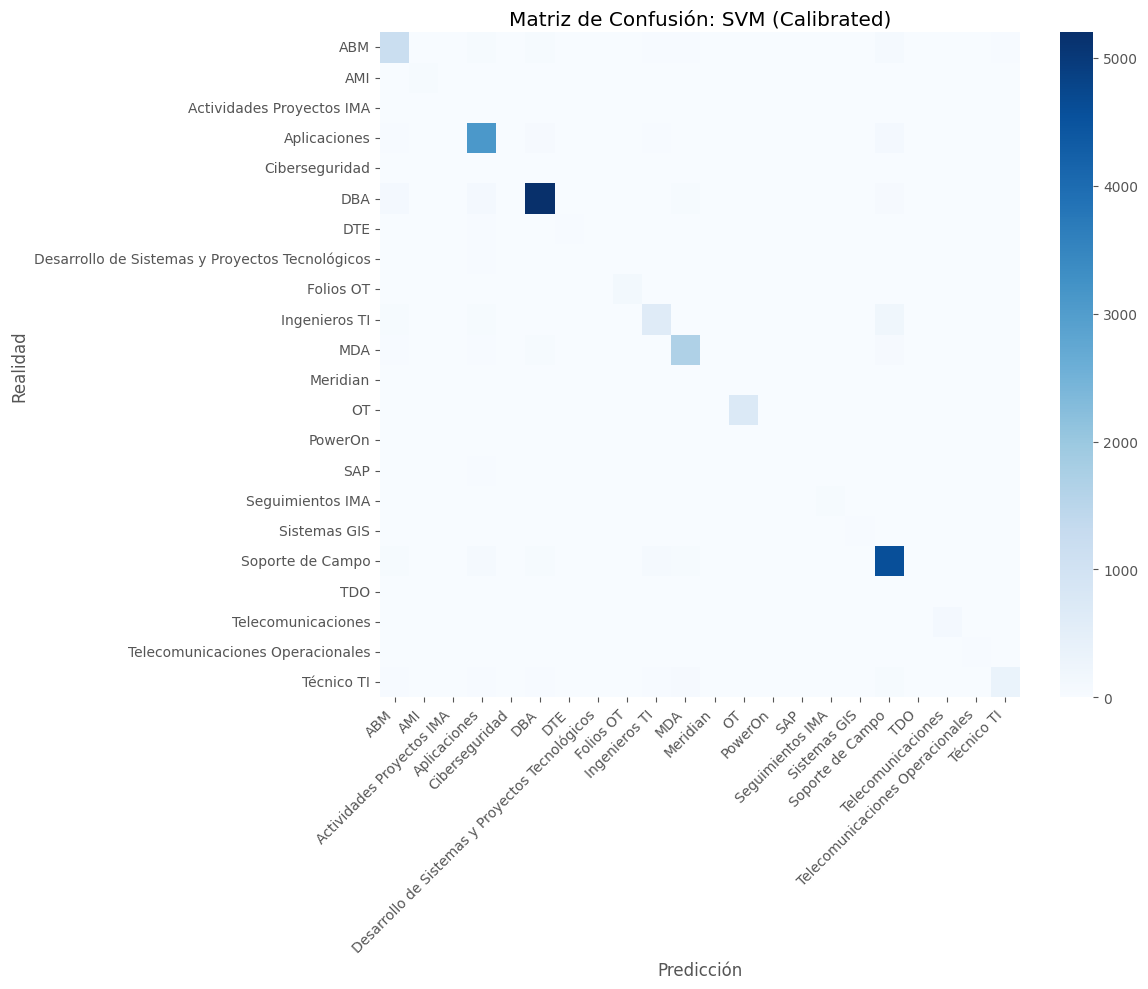

In [7]:
# Reconstruimos un DF temporal solo con train
df_train_temp = pd.DataFrame({'texto': X_train, 'label': y_train})
conteo_train = df_train_temp['label'].value_counts()
minimo_deseado = 300 # Umbral para inflar clases chicas

dfs_extra = []
for label_code, count in conteo_train.items():
    if count < minimo_deseado:
        # Calculamos multiplicador
        multiplicador = int(round(minimo_deseado / count))
        if multiplicador > 1:
            df_subset = df_train_temp[df_train_temp['label'] == label_code]
            # Duplicamos
            dfs_extra.append(pd.concat([df_subset] * (multiplicador - 1)))
            # print(f"   -> Clase {label_map[label_code]} aumentada x{multiplicador}")

if dfs_extra:
    df_train_bal = pd.concat([df_train_temp] + dfs_extra).sample(frac=1, random_state=42)
    X_train_bal = df_train_bal['texto']
    y_train_bal = df_train_bal['label']
    print(f"Dataset Train aumentado: {len(X_train)} -> {len(X_train_bal)}")
else:
    X_train_bal, y_train_bal = X_train, y_train

# --- 3. MODELOS (CON ESTRATEGIA C: CALIBRACIÓN) ---
modelos = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
    ]),
    # AQUI ESTA EL CAMBIO CLAVE PARA SVM: CalibratedClassifierCV
    'SVM (Calibrated)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', CalibratedClassifierCV(
            LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
            method='sigmoid', cv=3)
        )
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'))
    ])
}

# train
resultados = []

print("\n--- INICIO TRAINING DE MODELOS ---")
for nombre, pipe in modelos.items():
    inicio = time.time()
    try:
        # datos balanceados
        pipe.fit(X_train_bal, y_train_bal)
        
        # Predecir
        y_pred = pipe.predict(X_test)
        
        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        tiempo = time.time() - inicio
        resultados.append({'Modelo': nombre, 'Accuracy': acc, 'F1-Score': f1, 'Tiempo (s)': tiempo})
        print(f"✅ {nombre}: Acc={acc:.2%} | F1={f1:.2%} | {tiempo:.1f}s")
        
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Tabla de posiciones
df_res = pd.DataFrame(resultados).sort_values('F1-Score', ascending=False)
print("\nTABLA DE RESULTADOS:")
print(df_res)

# Analisi del mejor modelo
mejor_modelo_nombre = df_res.iloc[0]['Modelo']
mejor_pipeline = modelos[mejor_modelo_nombre]

print(f"\nAnalizando al ganador: {mejor_modelo_nombre}")

# probabilidades
probs = mejor_pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1) 
y_pred_indices = np.argmax(probs, axis=1) 
y_pred_final = mejor_pipeline.classes_[y_pred_indices]

# Reporte
print(classification_report(y_test, y_pred_final, target_names=list(label_map.values())))

#umbral de calidad
UMBRAL = 0.70 
print(f"\nSIMULACIÓN (Umbral {UMBRAL*100}%)")

y_test_array = np.array(y_test)
mask_auto = max_probs >= UMBRAL 

# Métricas Operativas
total_tickets = len(y_test)
auto_tickets = np.sum(mask_auto)
manual_tickets = total_tickets - auto_tickets

# Accuracy en los que si asignamos
if auto_tickets > 0:
    acc_operativo = accuracy_score(y_test_array[mask_auto], y_pred_final[mask_auto])
else:
    acc_operativo = 0

print(f"1. Cobertura Automática: {auto_tickets/total_tickets:.1%} ({auto_tickets} tickets)")
print(f"2. Precisión en Automático: {acc_operativo:.2%} (Esta es la fiabilidad real)")
print(f"3. Enviados a Manual: {manual_tickets/total_tickets:.1%} ({manual_tickets} tickets)")

# matriz de confusion
plt.figure(figsize=(12, 10))
nombres_clases = list(label_map.values())
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.title(f'Matriz de Confusión: {mejor_modelo_nombre}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
#guardar modelo
os.makedirs('../models', exist_ok=True)
path_modelo = '../models/SVM_best.pkl'
joblib.dump(mejor_pipeline, path_modelo)
print(f"Modelo guardado exitosamente en: {path_modelo}")

Modelo guardado exitosamente en: ../models/SVM_best.pkl


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import re

# --- 1. GENERACIÓN DE DATOS SINTÉTICOS (Generados por IA para ti) ---
# He creado variantes realistas para las clases donde el modelo fallaba (F1 bajo)
synthetic_data = {
    'SAP': [
        "error al ingresar a transaccion me21n", "sap gui se cierra solo inesperadamente",
        "no puedo liberar pedido en sap error de autorizacion", "bloqueo de usuario sap por intentos fallidos",
        "necesito acceso al modulo fi de sap", "error rfc en conexion con sap solution manager",
        "la pantalla de sap se queda congelada al exportar excel", "solicitud de rol para visualizar facturas sap",
        "dump en sistema sap productivo error time_out", "falla en carga masiva de datos a sap",
        "sap logon no conecta al servidor de desarrollo", "error abap en reporte z_ventas",
        "creacion de acreedor en sap da error de datos maestros", "problema con impresora local desde sap",
        "transaccion lenta en sap modulo mm", "error de logueo sap clave incorrecta",
        "solicito resetear password de sap mandante 300", "error de comunicacion idoc en sap",
        "mensaje de error al contabilizar en sap", "actualizacion de parche sap gui necesaria"
    ],
    'Ciberseguridad': [
        "correo sospechoso posible phishing de banco", "alerta de antivirus en mi equipo detecto malware",
        "bloqueo de pagina web por firewall corporativo", "solicitud de excepcion en proxy para sitio gobierno",
        "reporte de vulnerabilidad en servidor web", "intento de acceso no autorizado a mi cuenta",
        "computador lento y con ventanas emergentes virus", "necesito habilitar puerto usb bloqueado por seguridad",
        "analisis de seguridad para nuevo software", "correo con adjunto malicioso recibido",
        "alerta de seguridad de microsoft defender", "bloqueo de cuenta por politicas de seguridad",
        "sospecha de ransomware en carpeta compartida", "solicitud de acceso a vpn con doble factor",
        "cambio de politicas de contraseñas seguridad", "fuga de informacion detectada en log",
        "scan de vulnerabilidades solicita parche urgente", "sitio web marcado como inseguro por navegador",
        "notificacion de inicio de sesion desde pais extraño", "revision de permisos de carpeta sensible"
    ],
    'Desarrollo de Sistemas y Proyectos Tecnológicos': [
        "bug critico en despliegue de aplicacion web", "error 500 en api rest de facturacion",
        "fallo en pipeline de ci/cd jenkins", "base de datos de desarrollo no responde",
        "error de compilacion en proyecto java", "solicitud de merge request en gitlab",
        "problema con variable de entorno en produccion", "servicio docker se reinicia constantemente",
        "latencia alta en endpoint de consulta de clientes", "error de javascript en frontend react",
        "falla en integracion con pasarela de pagos", "actualizacion de libreria rompe compatibilidad",
        "hotfix urgente para error en calculo de iva", "script de migracion de datos falla",
        "error de conexion a base de datos mongo desde node", "revision de codigo para pase a produccion",
        "ambiente deqa no accesible", "logs de aplicacion muestran error de nullpointer",
        "timeout en servicio web soap", "rollback de version por fallas masivas"
    ],
    'PowerOn': [
        "sistema poweron no actualiza estado de clientes", "error de conexion con servidor poweron",
        "no puedo visualizar mapa en poweron", "falla en modulo de cortes de poweron",
        "usuario bloqueado en aplicativo poweron", "diferencia de datos entre poweron y sap",
        "lentitud extrema en consultas de poweron", "reporte de interrupciones poweron vacio",
        "error al asignar brigada en poweron", "poweron móvil no sincroniza datos",
        "alerta de falla en integracion scada poweron", "pantalla negra al abrir poweron",
        "error de licencia en terminal poweron", "solicitud de creacion de usuario poweron",
        "datos de empalme incorrectos en poweron", "falla al cerrar orden en poweron",
        "sistema poweron fuera de linea", "error de gis dentro de interfaz poweron",
        "actualizacion de poweron pendiente", "problema con despacho de ordenes poweron"
    ]
}

# Convertimos el diccionario a DataFrame
rows = []
for area, titulos in synthetic_data.items():
    for t in titulos:
        # Repetimos cada ejemplo sintético 5 veces para darle peso (Volumen)
        # Esto simula haber generado 100 tickets en vez de 20
        for _ in range(5): 
            rows.append({'titulo': t, 'area': area, 'origen': 'sintetico'})

df_synth = pd.DataFrame(rows)

# Limpieza de texto para los sintéticos
def limpiar_texto(texto):
    if not isinstance(texto, str): return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ ]', '', texto)
    return texto.strip()

df_synth['texto_limpio'] = df_synth['titulo'].apply(limpiar_texto)

# Label Encoding (Usamos el mismo encoder que ya tenías entrenado 'le')
# ¡OJO! Asegúrate de que 'le' exista. Si no, recréalo con df_train.
df_synth['label_code'] = le.transform(df_synth['area'])

print(f"🤖 Se han generado {len(df_synth)} tickets sintéticos de alta calidad.")

# --- 2. FUSIÓN: REAL + SINTÉTICO ---
# Tomamos tus datos de entrenamiento originales (X_train, y_train)
# Y le pegamos los sintéticos
X_train_augmented = pd.concat([X_train, df_synth['texto_limpio']])
y_train_augmented = pd.concat([y_train, df_synth['label_code']])

print(f"Dataset de Entrenamiento: {len(X_train)} -> Aumentado: {len(X_train_augmented)}")

# --- 3. RE-ENTRENAMIENTO DEL MODELO CLÁSICO (SVM) ---
print("\n--- Entrenando SVM con Datos Aumentados por IA ---")

# Usamos el Pipeline Ganador (SVM Calibrado)
pipeline_aug = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
        method='sigmoid', cv=3)
    )
])

pipeline_aug.fit(X_train_augmented, y_train_augmented)

# --- 4. EVALUACIÓN ---
# Evaluamos contra X_test ORIGINAL (Nunca evaluar con datos sintéticos)
y_pred_aug = pipeline_aug.predict(X_test)
acc_aug = accuracy_score(y_test, y_pred_aug)

print(f"\n🚀 Accuracy Nuevo (Data Augmentation): {acc_aug:.2%}")
print(classification_report(y_test, y_pred_aug, target_names=list(label_map.values())))

🤖 Se han generado 400 tickets sintéticos de alta calidad.
Dataset de Entrenamiento: 82060 -> Aumentado: 82460

--- Entrenando SVM con Datos Aumentados por IA ---

🚀 Accuracy Nuevo (Data Augmentation): 87.87%
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.81      0.79      1499
                                            AMI       0.81      0.74      0.77        65
                      Actividades Proyectos IMA       0.95      0.53      0.68        36
                                   Aplicaciones       0.87      0.90      0.88      3429
                                 Ciberseguridad       0.33      0.06      0.11        16
                                            DBA       0.96      0.93      0.94      5577
                                            DTE       0.70      0.60      0.65        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.00      0.00      0.00 

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [11]:
# --- CORRECCIÓN: ASEGURAR TIPOS COMPATIBLES ---

# 1. Reiniciamos X_train desde el DataFrame original para garantizar que sea Texto (Series)
# (Esto borra cualquier rastro de embeddings o arrays numéricos previos)
X_raw = df_labeled['texto_limpio']
y_raw = df_labeled['label_code']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

# 2. AHORA SÍ: FUSIÓN REAL + SINTÉTICO
# Usamos ignore_index=True para regenerar el índice y evitar duplicados
print(f"Fusionando {len(X_train)} reales con {len(df_synth)} sintéticos...")

# Aseguramos que los sintéticos sean Series también
X_synth_series = df_synth['texto_limpio']
y_synth_series = df_synth['label_code']

X_train_augmented = pd.concat([X_train, X_synth_series], ignore_index=True)
y_train_augmented = pd.concat([y_train, y_synth_series], ignore_index=True)

print(f"✅ Éxito: Dataset de Entrenamiento creció de {len(X_train)} a {len(X_train_augmented)} tickets.")

# --- 3. RE-ENTRENAMIENTO (SVM CALIBRADO) ---
print("\n--- Entrenando SVM con Datos Aumentados (Data Augmentation) ---")

pipeline_aug = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
        method='sigmoid', cv=3)
    )
])

pipeline_aug.fit(X_train_augmented, y_train_augmented)

# --- 4. EVALUACIÓN ---
y_pred_aug = pipeline_aug.predict(X_test)
acc_aug = accuracy_score(y_test, y_pred_aug)

print(f"\n🚀 Accuracy Nuevo (Data Augmentation): {acc_aug:.2%}")
print(classification_report(y_test, y_pred_aug, target_names=list(label_map.values())))

Fusionando 82060 reales con 400 sintéticos...
✅ Éxito: Dataset de Entrenamiento creció de 82060 a 82460 tickets.

--- Entrenando SVM con Datos Aumentados (Data Augmentation) ---

🚀 Accuracy Nuevo (Data Augmentation): 87.87%
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.81      0.79      1499
                                            AMI       0.81      0.74      0.77        65
                      Actividades Proyectos IMA       0.95      0.53      0.68        36
                                   Aplicaciones       0.87      0.90      0.88      3429
                                 Ciberseguridad       0.33      0.06      0.11        16
                                            DBA       0.96      0.93      0.94      5577
                                            DTE       0.70      0.60      0.65        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.00     

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [ ]:
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed"
df_ciber = df_all[df_all["area"] == "Ciberseguridad"][["categoria","titulo"]]
df_ciber.to_csv(f"{folder_p}/contexto_ciber.csv")

In [12]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. CARGAR Y LIMPIAR TUS DATOS REALES DE CIBERSEGURIDAD
path_ciber = '/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_ciber.csv'
df_ciber_real = pd.read_csv(path_ciber)

def limpiar_titulo_ciber(texto):
    if not isinstance(texto, str): return ""
    # Quitar ID al final (NNNN) y prefijos de correo
    texto = re.sub(r'\(\d+\)$', '', texto)
    texto = re.sub(r'^(RV|rv|Rv|RE|re|Re):\s*', '', texto)
    texto = re.sub(r'\[GLPI #\d+\]', '', texto)
    # Limpieza estándar
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ ]', '', texto)
    return texto.strip()

df_ciber_real['texto_limpio'] = df_ciber_real['titulo'].apply(limpiar_titulo_ciber)
print(f"✅ Cargados {len(df_ciber_real)} tickets reales de Ciberseguridad.")

# 2. PREPARACIÓN DE LAS ETIQUETAS
# Asumimos que 'le' es el LabelEncoder original que usaste para crear y_train.
# Convertimos y_train (números) de vuelta a TEXTO para poder mezclarlo.
y_train_text = le.inverse_transform(y_train)
y_train_text = pd.Series(y_train_text)

# 3. FUSIÓN Y AUGMENTATION
MULTIPLICADOR = 10 

print(f"Injectando tickets de Ciberseguridad (Multiplicados por {MULTIPLICADOR})...")

# Preparamos las Series de Ciberseguridad (Texto y Etiqueta)
X_ciber_series = df_ciber_real['texto_limpio']
y_ciber_series = pd.Series(['Ciberseguridad'] * len(df_ciber_real))

# Concatenamos repitiendo los datos de Ciberseguridad
# Nota: Usamos [X_ciber_series] * MULTIPLICADOR dentro del concat para repetir la lista
X_ciber_aug = pd.concat([X_ciber_series] * MULTIPLICADOR, ignore_index=True)
y_ciber_aug = pd.concat([y_ciber_series] * MULTIPLICADOR, ignore_index=True)

# 4. UNIÓN FINAL (Originales + Aumentados)
# Aseguramos que X_train sea Series y reiniciamos índices para evitar problemas
X_train_final = pd.concat([pd.Series(X_train), X_ciber_aug], ignore_index=True)
y_train_final_text = pd.concat([y_train_text, y_ciber_aug], ignore_index=True)

print(f"✅ Fusión Correcta: X={len(X_train_final)}, y={len(y_train_final_text)}")

# 5. RE-CODIFICACIÓN (CRUCIAL)
# Creamos un NUEVO encoder porque ahora tenemos más datos y quizás nuevas clases
le_final = LabelEncoder()
y_train_final_encoded = le_final.fit_transform(y_train_final_text)

# 6. ENTRENAMIENTO
pipeline_final = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))), 
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3))
])

print("Entrenando modelo final...")
# AQUÍ estaba el error: pasabas y_train_final (que no existía). Usamos el encoded.
pipeline_final.fit(X_train_final, y_train_final_encoded)

# 7. EVALUACIÓN
print("Evaluando...")

# Predecimos (nos da números basados en le_final)
y_pred_encoded = pipeline_final.predict(X_test)

# Invertimos la predicción a texto usando el NUEVO encoder
y_pred_text = le_final.inverse_transform(y_pred_encoded)

# Invertimos el y_test original a texto usando el VIEJO encoder (le)
# Esto es vital para comparar manzanas con manzanas
y_test_text = le.inverse_transform(y_test)

# Reporte
print(classification_report(y_test_text, y_pred_text))

✅ Cargados 78 tickets reales de Ciberseguridad.
Injectando tickets de Ciberseguridad (Multiplicados por 10)...
✅ Fusión Correcta: X=82840, y=82840
Entrenando modelo final...
Evaluando...
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.80      0.79      1499
                                            AMI       0.78      0.71      0.74        65
                      Actividades Proyectos IMA       0.87      0.56      0.68        36
                                   Aplicaciones       0.87      0.90      0.88      3429
                                 Ciberseguridad       0.47      0.88      0.61        16
                                            DBA       0.95      0.93      0.94      5577
                                            DTE       0.68      0.53      0.60        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.00      0.00      0.00        35
           

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [51]:
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed"
contexto_sistemas = df_all[df_all["area"] == "Desarrollo de Sistemas y Proyectos Tecnológicos"][["categoria","titulo"]]
contexto_sistemas.to_csv(f"{folder_p}/contexto_sistemas.csv")

In [41]:
#modelo SVM con contexto corregido y ampliado de Ciber y Sistemas
import pandas as pd
import numpy as np
import glob
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib

# --- 1. CONFIGURACIÓN Y FUNCIONES DE LIMPIEZA ---

def reparar_texto(texto):
    if not isinstance(texto, str): return texto
    # Diccionario de reemplazos comunes de encoding UTF-8 mal interpretado como Latin-1
    reemplazos = {
        'Ã³': 'ó', 'Ã¡': 'á', 'Ã©': 'é', 'Ã\xad': 'í', 'Ã': 'í',
        'Ã±': 'ñ', 'Ãº': 'ú', 'Ã\x81': 'Á', 'Ã\x89': 'É',
        'Ã\x8d': 'Í', 'Ã\x93': 'Ó', 'Ã\x9a': 'Ú', 'Ã\x91': 'Ñ',
        'â\x80\x93': '-', 'â\x80\x9c': '"', 'â\x80\x9d': '"',
        'Ã\xbc': 'ü', 'Ã\x80': 'À', 'Ã\x88': 'È', 'Ã\x82': 'Â',
        'Ã\x8a': 'Ê', 'Ã\x8e': 'Î', 'Ã\x94': 'Ô', 'Ã\x9b': 'Û',
        'Ã\x83': 'Ã', 'Ã\x95': 'Õ', 'Ã\x87': 'Ç', 'Ã\xae': 'î',
        'Ã\xb1': 'ñ', 'Ã¶': 'ö', 'Ã¤': 'ä', 'Ã§': 'ç'
    }
    for mal, bien in reemplazos.items():
        if mal in texto: texto = texto.replace(mal, bien)
    return texto.strip()

def limpiar_titulo(texto):
    if not isinstance(texto, str): return ""
    # Quitar ID al final (NNNN)
    texto = re.sub(r'\(\d+\)$', '', texto)
    # Quitar prefijos de correo
    texto = re.sub(r'^(RV|rv|Rv|RE|re|Re|Fwd|FWD|fwd):\s*', '', texto)
    # Quitar GLPI y etiquetas similares
    texto = re.sub(r'\[GLPI #\d+\]', '', texto)
    texto = re.sub(r'\[.*?\]', '', texto) # Quitar todo lo que esté entre corchetes
    
    # Limpieza estándar
    texto = texto.lower()
    texto = reparar_texto(texto).lower() # Asegurar que esté reparado antes de limpiar chars
    texto = re.sub(r'[^a-záéíóúñ0-9 ]', '', texto) # Dejamos números también por si acaso (modelos, errores)
    return texto.strip()

def procesar_jerarquia(df):
    if 'categoria' not in df.columns: return df
    series_cat = df['categoria'].fillna('Sin Categoria').astype(str)
    df['area'] = series_cat.apply(lambda x: x.split('>')[0].strip() if '>' in x else x.strip())
    df['area'] = df['area'].apply(reparar_texto)
    return df

# --- 2. CARGAR DATASET PRINCIPAL ---
# Buscamos los archivos originales procesados
path_main = '/home/ubuntu/projects/historical-analysis-management-tickets/data/processed'
all_files = glob.glob(os.path.join(path_main, "df*.csv"))

if not all_files:
    # Fallback si no encuentra la ruta larga, buscar en el directorio actual o subdirectorios
    all_files = glob.glob("**/df*.csv", recursive=True)

df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    if 'area' not in df.columns:
        df = procesar_jerarquia(df)
    df_list.append(df)

if df_list:
    df_all = pd.concat(df_list, axis=0, ignore_index=True)
    # Limpieza del dataset principal
    df_all['texto_limpio'] = df_all['titulo'].apply(limpiar_titulo)
    # Filtro básico
    df_labeled = df_all[df_all['area'] != 'Sin Categoria'].copy()
    # Filtro clases muy pequeñas (<20) para no ensuciar, EXCEPTO las que vamos a aumentar
    conteo = df_labeled['area'].value_counts()
    areas_validas = conteo[conteo > 20].index.tolist()
    # Aseguramos que Ciberseguridad y Desarrollo estén si no lo estaban
    for a in ['Ciberseguridad', 'Desarrollo de Sistemas y Proyectos Tecnológicos']:
        if a not in areas_validas: areas_validas.append(a)
    
    df_labeled = df_labeled[df_labeled['area'].isin(areas_validas)]
else:
    print("⚠️ No se encontró el dataset principal. Se usará solo el contexto proporcionado (Demo).")
    df_labeled = pd.DataFrame(columns=['texto_limpio', 'area']) # Vacío

print(f"Dataset Principal cargado: {len(df_labeled)} tickets")


# --- 3. CARGAR CONTEXTOS ESPECÍFICOS (CIBER + SISTEMAS) ---

# A. Ciberseguridad
try:
    df_ciber = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_ciber.csv')
    df_ciber['texto_limpio'] = df_ciber['titulo'].apply(limpiar_titulo)
    df_ciber['area'] = 'Ciberseguridad'
    print(f"✅ Contexto Ciberseguridad: {len(df_ciber)} tickets")
except:
    print("❌ No se encontró contexto_ciber.csv")
    df_ciber = pd.DataFrame()

# B. Sistemas / Desarrollo
try:
    df_sistemas = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_sistemas.csv')
    # Reparar encoding específicamente para este archivo que el usuario mencionó
    df_sistemas['titulo'] = df_sistemas['titulo'].apply(reparar_texto)
    df_sistemas['categoria'] = df_sistemas['categoria'].apply(reparar_texto)
    
    df_sistemas['texto_limpio'] = df_sistemas['titulo'].apply(limpiar_titulo)
    # Normalizamos el nombre del área para que coincida con el dataset principal o sea el estándar
    # El usuario lo llama "Desarrollo de Sistemas y Proyectos Tecnológicos" en el CSV
    df_sistemas['area'] = 'Desarrollo de Sistemas y Proyectos Tecnológicos'
    print(f"✅ Contexto Sistemas: {len(df_sistemas)} tickets")
except:
    print("❌ No se encontró contexto_sistemas.csv")
    df_sistemas = pd.DataFrame()


# --- 4. PREPARACIÓN DE DATOS DE ENTRENAMIENTO ---

# X e y originales
X_raw = df_labeled['texto_limpio']
y_raw = df_labeled['area']

# Split Train/Test (80/20) - Estratificado
# Si hay clases con 1 solo elemento, el stratify fallará, así que lo manejamos
try:
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
except ValueError:
    # Fallback sin stratify si hay clases muy pequeñas
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

# --- 5. DATA AUGMENTATION (INYECCIÓN DE CONTEXTO) ---

MULTIPLICADOR_CIBER = 20 # Aumentamos el peso un poco más para asegurar aprendizaje
MULTIPLICADOR_SISTEMAS = 20

# Preparamos listas para concatenar
X_aug_list = []
y_aug_list = []

# Añadir Ciberseguridad Aumentado
if not df_ciber.empty:
    X_aug_list.append(pd.concat([df_ciber['texto_limpio']] * MULTIPLICADOR_CIBER, ignore_index=True))
    y_aug_list.append(pd.concat([df_ciber['area']] * MULTIPLICADOR_CIBER, ignore_index=True))

# Añadir Sistemas Aumentado
if not df_sistemas.empty:
    X_aug_list.append(pd.concat([df_sistemas['texto_limpio']] * MULTIPLICADOR_SISTEMAS, ignore_index=True))
    y_aug_list.append(pd.concat([df_sistemas['area']] * MULTIPLICADOR_SISTEMAS, ignore_index=True))

# Concatenar al Train Set
if X_aug_list:
    X_aug_combined = pd.concat(X_aug_list, ignore_index=True)
    y_aug_combined = pd.concat(y_aug_list, ignore_index=True)
    
    # Unir con el Train original
    X_train_final = pd.concat([X_train, X_aug_combined], ignore_index=True)
    y_train_final = pd.concat([y_train, y_aug_combined], ignore_index=True)
    print(f"🚀 Data Augmentation aplicada. Train set creció de {len(X_train)} a {len(X_train_final)}")
else:
    X_train_final = X_train
    y_train_final = y_train
    print("⚠️ No hubo Data Augmentation.")

# --- 6. LABEL ENCODING ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_final)
y_test_encoded = le.transform(y_test) # Usamos transform, cuidado con clases nuevas en test no vistas (no debería pasar con el split)

# --- 7. ENTRENAMIENTO MODELO ---
print("\nEntrenando SVM Calibrado...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced', random_state=42), cv=3))
])

pipeline.fit(X_train_final, y_train_encoded)

# --- 8. EVALUACIÓN ---
print("\nEvaluando modelo...")
y_pred_encoded = pipeline.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

# Reporte Clasificación
print("\n--- REPORTE DE CLASIFICACIÓN DETALLADO ---")
print(classification_report(y_test, y_pred))

# Métricas Globales
acc = accuracy_score(y_test, y_pred)
print(f"\n🏆 Accuracy Global: {acc:.2%}")

# Análisis "Despachador Inteligente"
probs = pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1)
UMBRAL = 0.70

auto_mask = max_probs >= UMBRAL
acc_auto = accuracy_score(y_test_encoded[auto_mask], y_pred_encoded[auto_mask])
cobertura = np.mean(auto_mask)

print("\n--- MÉTRICAS DEL DESPACHADOR (UMBRAL 70%) ---")
print(f"✅ Cobertura Automática: {cobertura:.1%} (Tickets que la IA responde)")
print(f"🎯 Precisión en Automático: {acc_auto:.2%} (Fiabilidad real)")
print(f"👀 Revisión Manual: {1-cobertura:.1%} (Tickets derivados a humanos)")

Dataset Principal cargado: 102599 tickets
✅ Contexto Ciberseguridad: 78 tickets
✅ Contexto Sistemas: 173 tickets
🚀 Data Augmentation aplicada. Train set creció de 82079 a 87099

Entrenando SVM Calibrado...

Evaluando modelo...

--- REPORTE DE CLASIFICACIÓN DETALLADO ---
                                                 precision    recall  f1-score   support

                                            ABM       0.75      0.78      0.76      1499
                                            AMI       0.74      0.49      0.59        65
                      Actividades Proyectos IMA       0.81      0.47      0.60        36
                                   Aplicaciones       0.81      0.87      0.84      3429
                                 Ciberseguridad       0.31      1.00      0.48        16
                                            DBA       0.90      0.89      0.89      5577
                                            DTE       0.71      0.51      0.59        53
Desarrollo de Si

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


🏆 Accuracy Global: 85.09%

--- MÉTRICAS DEL DESPACHADOR (UMBRAL 70%) ---
✅ Cobertura Automática: 78.4% (Tickets que la IA responde)
🎯 Precisión en Automático: 95.00% (Fiabilidad real)
👀 Revisión Manual: 21.6% (Tickets derivados a humanos)


In [ ]:
#sin contexto
import pandas as pd
import numpy as np
import re
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

def decidir_accion(clase_predicha, confianza):
    """
    Define si un ticket se auto-asigna (SVM) o se va al Agente (IA)
    basado en reglas específicas por categoría.
    """
    
    # REGLA 1: Clases "Nobles" (Suelen ser correctas incluso con baja confianza)
    # ABM y Ciberseguridad tienen palabras clave muy fuertes. Si el modelo dice que es eso, créele.
    if clase_predicha in ['ABM', 'Ciberseguridad', 'DBA']:
        if confianza >= 0.60:  # Bajamos la vara a 60%
            return "SVM (Auto-Asignar)"

    # REGLA 2: Clases "Peligrosas" (Suelen confundirse entre sí)
    # Aplicaciones, Soporte y Sistemas se parecen mucho. Exigimos alta seguridad.
    if clase_predicha in ['Aplicaciones', 'Soporte de Campo', 'Desarrollo de Sistemas']:
        if confianza >= 0.80:  # Mantenemos la vara alta
            return "SVM (Auto-Asignar)"

    # REGLA 3: Default
    # Para el resto, un punto medio
    if confianza >= 0.75:
        return "SVM (Auto-Asignar)"
    
    # Si no pasa ningún filtro -> Agente IA
    return "Agente IA"

# --- 1. CARGA DE DATOS COMPLETOS (TU HISTÓRICO) ---
# Ajusta la ruta a donde tengas tus CSVs procesados
path_historico = '/home/ubuntu/projects/historical-analysis-management-tickets/data/processed' # <--- TU RUTA REAL
all_files = glob.glob(os.path.join(path_historico, "df*.csv"))

print(f"📂 Cargando histórico desde {len(all_files)} archivos...")
df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

# Limpieza básica para asegurar columnas
if 'area' not in df_all.columns:
    if 'categoria' in df_all.columns:
        df_all['area'] = df_all['categoria'].fillna('Sin Categoria').apply(lambda x: str(x).split('>')[0].strip())
    else:
        raise ValueError("No encuentro columna 'area' ni 'categoria'")

# --- 2. CARGA DE CONTEXTO EXTRA (CIBER Y SISTEMAS) ---
try:
    df_ciber = pd.read_csv('contexto_ciber.csv')
    df_sistemas = pd.read_csv('contexto_sistemas.csv')
    print("✅ Contextos extra cargados.")
except:
    print("⚠️ No encontré los archivos de contexto (ciber/sistemas). Usando solo histórico.")
    df_ciber = pd.DataFrame()
    df_sistemas = pd.DataFrame()

# Función de Limpieza Unificada
def limpiar_texto(texto):
    if not isinstance(texto, str): return ""
    texto = texto.lower()
    # Quitar basura común de emails y sistemas
    texto = re.sub(r'\(\d+\)$', '', texto) # IDs al final (12345)
    texto = re.sub(r'^(rv|re|fwd|enc):\s*', '', texto) # Prefijos email
    texto = re.sub(r'\[glpi #\d+\]', '', texto) # Prefijos tickets
    texto = re.sub(r'[^a-záéíóúñ0-9 ]', '', texto) # Solo letras y números
    return texto.strip()

# Aplicar limpieza
print("🧹 Limpiando textos...")
df_all['texto_limpio'] = df_all['titulo'].apply(limpiar_texto)

# --- CORRECCIÓN: FILTRAR CLASES PEQUEÑAS ---
# Identificamos clases con menos de 5 tickets (ruido)
min_tickets_validos = 5 
conteo_areas = df_all['area'].value_counts()
areas_validas = conteo_areas[conteo_areas >= min_tickets_validos].index
areas_descartadas = conteo_areas[conteo_areas < min_tickets_validos].index

print(f"📉 Eliminando {len(areas_descartadas)} categorías con menos de {min_tickets_validos} tickets...")
print(f"   (Ejemplos descartados: {list(areas_descartadas)[:5]})")

# Filtramos el DataFrame
df_all = df_all[df_all['area'].isin(areas_validas)].copy()

df_all = df_all[df_all['area'] != 'Sin Categoria'] # Quitamos basura

if not df_ciber.empty:
    df_ciber['texto_limpio'] = df_ciber['titulo'].apply(limpiar_texto)
    df_ciber['area'] = 'Ciberseguridad'

if not df_sistemas.empty:
    df_sistemas['texto_limpio'] = df_sistemas['titulo'].apply(limpiar_texto)
    df_sistemas['area'] = 'Desarrollo de Sistemas y Proyectos Tecnológicos' # Nombre exacto de tu histórico

# --- 3. PREPARACIÓN DEL TRAIN SET (CON AUGMENTATION) ---
X = df_all['texto_limpio']
y = df_all['area']

# Split para validar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("🚀 Aplicando Inyección de Contexto (Data Augmentation)...")

# Recuperamos X e y como DataFrames para concatenar fácil
X_train_aug = X_train.copy()
y_train_aug = y_train.copy()

# Aumentamos Ciberseguridad (x5)
if not df_ciber.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_ciber['texto_limpio']] * 5, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_ciber['area']] * 5, ignore_index=True)

# Aumentamos Sistemas (x8) - Un poco más porque es confuso
if not df_sistemas.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_sistemas['texto_limpio']] * 8, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_sistemas['area']] * 8, ignore_index=True)

# Codificación de etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_aug)

print(f"📊 Tickets para entrenar: {len(X_train_aug)}")

# --- 4. ENTRENAMIENTO DEL MODELO HÍBRIDO ---
print("🧠 Entrenando SVM Calibrado (Esto tomará unos segundos)...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3))
])

pipeline.fit(X_train_aug, y_train_encoded)

# --- 5. SIMULACIÓN DEL ROUTER (SVM vs AGENTE) ---
print("\n--- 🚦 EJECUTANDO ROUTER DE TRÁFICO ---")

# Predecimos Probabilidades en el Test Set
probs = pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1) # Qué tan seguro está el modelo (0 a 1)
pred_indices = np.argmax(probs, axis=1)
pred_labels = le.inverse_transform(pred_indices)

# DEFINICIÓN DEL UMBRAL
# Si la confianza es menor a esto, se va al Agente.
UMBRAL_CONFIANZA = 0.75 

acciones = []
razones = []

acciones = []
razones = []

# Iteramos sobre cada predicción
for prob, label in zip(max_probs, pred_labels):
    decision = decidir_accion(label, prob) # Usamos la función inteligente
    
    acciones.append(decision)
    if decision == "SVM (Auto-Asignar)":
        razones.append(f"Aprobado por Regla {label} (Conf {prob:.2f})")
    else:
        razones.append(f"Duda razonable (Conf {prob:.2f})")

# Crear DataFrame y revisar
df_final = pd.DataFrame({
    'Ticket': X_test.values,
    'Prediccion': pred_labels,
    'Confianza': max_probs,
    'Accion': acciones,
    'Razon': razones
})

print(df_final['Accion'].value_counts())

# DataFrame de Resultados
df_res = pd.DataFrame({
    'Ticket': X_test.values,
    'Real': y_test.values,
    'Prediccion_SVM': pred_labels,
    'Confianza': max_probs,
    'Accion': acciones
})

# --- 6. ANÁLISIS DE RESULTADOS (CORREGIDO) ---

print("\n📊 DIAGNÓSTICO DE ETIQUETAS:")
print(df_res['Accion'].value_counts())

# Detectamos automáticamente qué etiqueta de SVM se usó
etiqueta_svm = None
if 'SVM (Auto-Asignar)' in df_res['Accion'].unique():
    etiqueta_svm = 'SVM (Auto-Asignar)'
elif 'SVM (Auto)' in df_res['Accion'].unique():
    etiqueta_svm = 'SVM (Auto)'

# Filtramos usando la etiqueta correcta
if etiqueta_svm:
    svm_tickets = df_res[df_res['Accion'] == etiqueta_svm]
    agent_tickets = df_res[df_res['Accion'] != etiqueta_svm] # Todo lo que no sea SVM es Agente
    
    print(f"\n✅ RESUMEN:")
    print(f"   🟢 Atendidos por SVM: {len(svm_tickets)} ({len(svm_tickets)/len(df_res):.1%})")
    print(f"   🔴 Derivados al Agente: {len(agent_tickets)} ({len(agent_tickets)/len(df_res):.1%})")

    # Calculamos precisión SOLO si hay tickets
    if len(svm_tickets) > 0:
        acc_svm = accuracy_score(svm_tickets['Real'], svm_tickets['Prediccion_SVM']) # O 'Prediccion' según tu DF
        print(f"\n🎯 Precisión de la SVM (en tickets auto-asignados): {acc_svm:.2%}")
    else:
        print("\n⚠️ RARO: La SVM encontró tickets pero no pudimos calcular precisión.")

else:
    print("\n⚠️ ALERTA CRÍTICA: Ningún ticket fue asignado a la SVM.")
    print("   Posibles causas:")
    print("   1. El umbral de confianza es demasiado alto.")
    print("   2. El modelo no aprendió bien (revisa si X_train no quedó vacío por los filtros).")
    print("   3. Todos los tickets se fueron a 'Agente IA' o 'Duda'.")
    
    # Si todo falló, asumimos que todo es para el agente para que puedas ver el CSV
    agent_tickets = df_res.copy()

# --- 7. EXPORTAR TICKETS DIFÍCILES ---
print("\n💾 Guardando tickets para el Agente...")
agent_tickets.to_csv('tickets_para_agente_ia.csv', index=False)
print("   -> Archivo generado correctamente.")

In [48]:
import pandas as pd
import numpy as np
import re
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

def decidir_accion(clase_predicha, confianza):
    """
    Define si un ticket se auto-asigna (SVM) o se va al Agente (IA)
    basado en reglas específicas por categoría.
    """
    
    # REGLA 1: Clases "Nobles" (Suelen ser correctas incluso con baja confianza)
    # ABM y Ciberseguridad tienen palabras clave muy fuertes. Si el modelo dice que es eso, créele.
    if clase_predicha in ['ABM', 'Ciberseguridad', 'DBA']:
        if confianza >= 0.60:  # Bajamos la vara a 60%
            return "SVM (Auto-Asignar)"

    # REGLA 2: Clases "Peligrosas" (Suelen confundirse entre sí)
    # Aplicaciones, Soporte y Sistemas se parecen mucho. Exigimos alta seguridad.
    if clase_predicha in ['Aplicaciones', 'Soporte de Campo', 'Desarrollo de Sistemas']:
        if confianza >= 0.80:  # Mantenemos la vara alta
            return "SVM (Auto-Asignar)"

    # REGLA 3: Default
    # Para el resto, un punto medio
    if confianza >= 0.75:
        return "SVM (Auto-Asignar)"
    
    # Si no pasa ningún filtro -> Agente IA
    return "Agente IA"

# --- 1. CARGA DE DATOS COMPLETOS (TU HISTÓRICO) ---
# Ajusta la ruta a donde tengas tus CSVs procesados
path_historico = '/home/ubuntu/projects/historical-analysis-management-tickets/data/processed' # <--- TU RUTA REAL
all_files = glob.glob(os.path.join(path_historico, "df*.csv"))

print(f"📂 Cargando histórico desde {len(all_files)} archivos...")
df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

# Limpieza básica para asegurar columnas
if 'area' not in df_all.columns:
    if 'categoria' in df_all.columns:
        df_all['area'] = df_all['categoria'].fillna('Sin Categoria').apply(lambda x: str(x).split('>')[0].strip())
    else:
        raise ValueError("No encuentro columna 'area' ni 'categoria'")

# --- 2. CARGA DE CONTEXTO EXTRA (CIBER Y SISTEMAS) ---
try:
    df_ciber = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_ciber.csv')
    df_sistemas = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_sistemas.csv')
    print("✅ Contextos extra cargados.")
except:
    print("⚠️ No encontré los archivos de contexto (ciber/sistemas). Usando solo histórico.")
    df_ciber = pd.DataFrame()
    df_sistemas = pd.DataFrame()

# Función de Limpieza Unificada
def limpiar_texto(texto):
    if not isinstance(texto, str): return ""
    texto = texto.lower()
    # Quitar basura común de emails y sistemas
    texto = re.sub(r'\(\d+\)$', '', texto) # IDs al final (12345)
    texto = re.sub(r'^(rv|re|fwd|enc):\s*', '', texto) # Prefijos email
    texto = re.sub(r'\[glpi #\d+\]', '', texto) # Prefijos tickets
    texto = re.sub(r'[^a-záéíóúñ0-9 ]', '', texto) # Solo letras y números
    return texto.strip()

# Aplicar limpieza
print("🧹 Limpiando textos...")
df_all['texto_limpio'] = df_all['titulo'].apply(limpiar_texto)

# --- CORRECCIÓN: FILTRAR CLASES PEQUEÑAS ---
# Identificamos clases con menos de 5 tickets (ruido)
min_tickets_validos = 5 
conteo_areas = df_all['area'].value_counts()
areas_validas = conteo_areas[conteo_areas >= min_tickets_validos].index
areas_descartadas = conteo_areas[conteo_areas < min_tickets_validos].index

print(f"📉 Eliminando {len(areas_descartadas)} categorías con menos de {min_tickets_validos} tickets...")
print(f"   (Ejemplos descartados: {list(areas_descartadas)[:5]})")

# Filtramos el DataFrame
df_all = df_all[df_all['area'].isin(areas_validas)].copy()

df_all = df_all[df_all['area'] != 'Sin Categoria'] # Quitamos basura

if not df_ciber.empty:
    df_ciber['texto_limpio'] = df_ciber['titulo'].apply(limpiar_texto)
    df_ciber['area'] = 'Ciberseguridad'

if not df_sistemas.empty:
    df_sistemas['texto_limpio'] = df_sistemas['titulo'].apply(limpiar_texto)
    df_sistemas['area'] = 'Desarrollo de Sistemas y Proyectos Tecnológicos' # Nombre exacto de tu histórico

# --- 3. PREPARACIÓN DEL TRAIN SET (CON AUGMENTATION) ---
X = df_all['texto_limpio']
y = df_all['area']

# Split para validar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("🚀 Aplicando Inyección de Contexto (Data Augmentation)...")

# Recuperamos X e y como DataFrames para concatenar fácil
X_train_aug = X_train.copy()
y_train_aug = y_train.copy()

# Aumentamos Ciberseguridad (x5)
if not df_ciber.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_ciber['texto_limpio']] * 5, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_ciber['area']] * 5, ignore_index=True)

# Aumentamos Sistemas (x8) - Un poco más porque es confuso
if not df_sistemas.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_sistemas['texto_limpio']] * 8, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_sistemas['area']] * 8, ignore_index=True)

# Codificación de etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_aug)

print(f"📊 Tickets para entrenar: {len(X_train_aug)}")

# --- 4. ENTRENAMIENTO DEL MODELO HÍBRIDO ---
print("🧠 Entrenando SVM Calibrado (Esto tomará unos segundos)...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3))
])

pipeline.fit(X_train_aug, y_train_encoded)

# --- 5. SIMULACIÓN DEL ROUTER (SVM vs AGENTE) ---
print("\n--- 🚦 EJECUTANDO ROUTER DE TRÁFICO ---")

# Predecimos Probabilidades en el Test Set
probs = pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1) # Qué tan seguro está el modelo (0 a 1)
pred_indices = np.argmax(probs, axis=1)
pred_labels = le.inverse_transform(pred_indices)

# DEFINICIÓN DEL UMBRAL
# Si la confianza es menor a esto, se va al Agente.
UMBRAL_CONFIANZA = 0.75 

acciones = []
razones = []

acciones = []
razones = []

# Iteramos sobre cada predicción
for prob, label in zip(max_probs, pred_labels):
    decision = decidir_accion(label, prob) # Usamos la función inteligente
    
    acciones.append(decision)
    if decision == "SVM (Auto-Asignar)":
        razones.append(f"Aprobado por Regla {label} (Conf {prob:.2f})")
    else:
        razones.append(f"Duda razonable (Conf {prob:.2f})")

# Crear DataFrame y revisar
df_final = pd.DataFrame({
    'Ticket': X_test.values,
    'Prediccion': pred_labels,
    'Confianza': max_probs,
    'Accion': acciones,
    'Razon': razones
})

print(df_final['Accion'].value_counts())

# DataFrame de Resultados
df_res = pd.DataFrame({
    'Ticket': X_test.values,
    'Real': y_test.values,
    'Prediccion_SVM': pred_labels,
    'Confianza': max_probs,
    'Accion': acciones
})

# --- 6. ANÁLISIS DE RESULTADOS (CORREGIDO) ---

print("\n📊 DIAGNÓSTICO DE ETIQUETAS:")
print(df_res['Accion'].value_counts())

# Detectamos automáticamente qué etiqueta de SVM se usó
etiqueta_svm = None
if 'SVM (Auto-Asignar)' in df_res['Accion'].unique():
    etiqueta_svm = 'SVM (Auto-Asignar)'
elif 'SVM (Auto)' in df_res['Accion'].unique():
    etiqueta_svm = 'SVM (Auto)'

# Filtramos usando la etiqueta correcta
if etiqueta_svm:
    svm_tickets = df_res[df_res['Accion'] == etiqueta_svm]
    agent_tickets = df_res[df_res['Accion'] != etiqueta_svm] # Todo lo que no sea SVM es Agente
    
    print(f"\n✅ RESUMEN:")
    print(f"   🟢 Atendidos por SVM: {len(svm_tickets)} ({len(svm_tickets)/len(df_res):.1%})")
    print(f"   🔴 Derivados al Agente: {len(agent_tickets)} ({len(agent_tickets)/len(df_res):.1%})")

    # Calculamos precisión SOLO si hay tickets
    if len(svm_tickets) > 0:
        acc_svm = accuracy_score(svm_tickets['Real'], svm_tickets['Prediccion_SVM']) # O 'Prediccion' según tu DF
        print(f"\n🎯 Precisión de la SVM (en tickets auto-asignados): {acc_svm:.2%}")
    else:
        print("\n⚠️ RARO: La SVM encontró tickets pero no pudimos calcular precisión.")

else:
    print("\n⚠️ ALERTA CRÍTICA: Ningún ticket fue asignado a la SVM.")
    print("   Posibles causas:")
    print("   1. El umbral de confianza es demasiado alto.")
    print("   2. El modelo no aprendió bien (revisa si X_train no quedó vacío por los filtros).")
    print("   3. Todos los tickets se fueron a 'Agente IA' o 'Duda'.")
    
    # Si todo falló, asumimos que todo es para el agente para que puedas ver el CSV
    agent_tickets = df_res.copy()

# --- 7. EXPORTAR TICKETS DIFÍCILES ---
print("\n💾 Guardando tickets para el Agente...")
agent_tickets.to_csv('tickets_para_agente_ia.csv', index=False)
print("   -> Archivo generado correctamente.")

📂 Cargando histórico desde 5 archivos...
✅ Contextos extra cargados.
🧹 Limpiando textos...
📉 Eliminando 7 categorías con menos de 5 tickets...
   (Ejemplos descartados: ['Redirección Correo', 'Análisis Nessus', 'OSF - Archivos OSF', 'Servicio Docker', 'Tecnored - Sistemas'])
🚀 Aplicando Inyección de Contexto (Data Augmentation)...
📊 Tickets para entrenar: 83903
🧠 Entrenando SVM Calibrado (Esto tomará unos segundos)...

--- 🚦 EJECUTANDO ROUTER DE TRÁFICO ---
Accion
SVM (Auto-Asignar)    16401
Agente IA              4132
Name: count, dtype: int64

📊 DIAGNÓSTICO DE ETIQUETAS:
Accion
SVM (Auto-Asignar)    16401
Agente IA              4132
Name: count, dtype: int64

✅ RESUMEN:
   🟢 Atendidos por SVM: 16401 (79.9%)
   🔴 Derivados al Agente: 4132 (20.1%)

🎯 Precisión de la SVM (en tickets auto-asignados): 96.18%

💾 Guardando tickets para el Agente...
   -> Archivo generado correctamente.


In [50]:
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed"
contexto_sistemas = df_all[df_all["area"] == "SAP"][["categoria","titulo"]]
contexto_sistemas.to_csv(f"{folder_p}/contexto_sap.csv")

In [54]:
import pandas as pd
import numpy as np
import re
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

def decidir_accion(clase_predicha, confianza):
    """
    Define si un ticket se auto-asigna (SVM) o se va al Agente (IA)
    basado en reglas específicas por categoría.
    """
    
    # REGLA 1: Clases "Nobles" (Suelen ser correctas incluso con baja confianza)
    # ABM y Ciberseguridad tienen palabras clave muy fuertes. Si el modelo dice que es eso, créele.
    if clase_predicha in ['ABM', 'Ciberseguridad', 'DBA']:
        if confianza >= 0.60:  # Bajamos la vara a 60%
            return "SVM (Auto-Asignar)"

    # REGLA 2: Clases "Peligrosas" (Suelen confundirse entre sí)
    # Aplicaciones, Soporte y Sistemas se parecen mucho. Exigimos alta seguridad.
    if clase_predicha in ['Aplicaciones', 'Soporte de Campo', 'Desarrollo de Sistemas']:
        if confianza >= 0.80:  # Mantenemos la vara alta
            return "SVM (Auto-Asignar)"

    # REGLA 3: Default
    # Para el resto, un punto medio
    if confianza >= 0.75:
        return "SVM (Auto-Asignar)"
    
    # Si no pasa ningún filtro -> Agente IA
    return "Agente IA"

# --- 1. CARGA DE DATOS COMPLETOS (TU HISTÓRICO) ---
# Ajusta la ruta a donde tengas tus CSVs procesados
path_historico = '/home/ubuntu/projects/historical-analysis-management-tickets/data/processed' # <--- TU RUTA REAL
all_files = glob.glob(os.path.join(path_historico, "df*.csv"))

print(f"📂 Cargando histórico desde {len(all_files)} archivos...")
df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

# Limpieza básica para asegurar columnas
if 'area' not in df_all.columns:
    if 'categoria' in df_all.columns:
        df_all['area'] = df_all['categoria'].fillna('Sin Categoria').apply(lambda x: str(x).split('>')[0].strip())
    else:
        raise ValueError("No encuentro columna 'area' ni 'categoria'")

# --- 2. CARGA DE CONTEXTO EXTRA (CIBER Y SISTEMAS) ---
try:
    df_ciber = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_ciber.csv')
    df_sistemas = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_sistemas.csv')
    df_sap = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_sap.csv')
    print("✅ Contextos extra cargados.")
except:
    print("⚠️ No encontré los archivos de contexto (ciber/sistemas). Usando solo histórico.")
    df_ciber = pd.DataFrame()
    df_sistemas = pd.DataFrame()
    df_sap = pd.DataFrame()

# Función de Limpieza Unificada
def limpiar_texto(texto):
    if not isinstance(texto, str): return ""
    texto = texto.lower()
    # Quitar basura común de emails y sistemas
    texto = re.sub(r'\(\d+\)$', '', texto) # IDs al final (12345)
    texto = re.sub(r'^(rv|re|fwd|enc):\s*', '', texto) # Prefijos email
    texto = re.sub(r'\[glpi #\d+\]', '', texto) # Prefijos tickets
    texto = re.sub(r'[^a-záéíóúñ0-9 ]', '', texto) # Solo letras y números
    return texto.strip()

# Aplicar limpieza
print("🧹 Limpiando textos...")
df_all['texto_limpio'] = df_all['titulo'].apply(limpiar_texto)

# --- CORRECCIÓN: FILTRAR CLASES PEQUEÑAS ---
# Identificamos clases con menos de 5 tickets (ruido)
min_tickets_validos = 5 
conteo_areas = df_all['area'].value_counts()
areas_validas = conteo_areas[conteo_areas >= min_tickets_validos].index
areas_descartadas = conteo_areas[conteo_areas < min_tickets_validos].index

print(f"📉 Eliminando {len(areas_descartadas)} categorías con menos de {min_tickets_validos} tickets...")
print(f"   (Ejemplos descartados: {list(areas_descartadas)[:5]})")

# Filtramos el DataFrame
df_all = df_all[df_all['area'].isin(areas_validas)].copy()

df_all = df_all[df_all['area'] != 'Sin Categoria'] # Quitamos basura

if not df_ciber.empty:
    df_ciber['texto_limpio'] = df_ciber['titulo'].apply(limpiar_texto)
    df_ciber['area'] = 'Ciberseguridad'

if not df_sistemas.empty:
    df_sistemas['texto_limpio'] = df_sistemas['titulo'].apply(limpiar_texto)
    df_sistemas['area'] = 'Desarrollo de Sistemas y Proyectos Tecnológicos' # Nombre exacto de tu histórico

if not df_sap.empty:
    df_sap['texto_limpio'] = df_sap['titulo'].apply(limpiar_texto)
    df_sap['area'] = 'SAP'

# --- 3. PREPARACIÓN DEL TRAIN SET (CON AUGMENTATION) ---
X = df_all['texto_limpio']
y = df_all['area']

# Split para validar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("🚀 Aplicando Inyección de Contexto (Data Augmentation)...")

# Recuperamos X e y como DataFrames para concatenar fácil
X_train_aug = X_train.copy()
y_train_aug = y_train.copy()

# Aumentamos Ciberseguridad (x5)
if not df_ciber.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_ciber['texto_limpio']] * 5, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_ciber['area']] * 5, ignore_index=True)

# Aumentamos Sistemas (x8) - Un poco más porque es confuso
if not df_sistemas.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_sistemas['texto_limpio']] * 8, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_sistemas['area']] * 8, ignore_index=True)

if not df_sap.empty:
    X_train_aug = pd.concat([X_train_aug] + [df_sap['texto_limpio']] * 8, ignore_index=True)
    y_train_aug = pd.concat([y_train_aug] + [df_sap['area']] * 8, ignore_index=True)

# Codificación de etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_aug)

print(f"📊 Tickets para entrenar: {len(X_train_aug)}")

# --- 4. ENTRENAMIENTO DEL MODELO HÍBRIDO ---
print("🧠 Entrenando SVM Calibrado (Esto tomará unos segundos)...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3))
])

pipeline.fit(X_train_aug, y_train_encoded)

# --- 5. SIMULACIÓN DEL ROUTER (SVM vs AGENTE) ---
print("\n--- 🚦 EJECUTANDO ROUTER DE TRÁFICO ---")

# Predecimos Probabilidades en el Test Set
probs = pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1) # Qué tan seguro está el modelo (0 a 1)
pred_indices = np.argmax(probs, axis=1)
pred_labels = le.inverse_transform(pred_indices)

# DEFINICIÓN DEL UMBRAL
# Si la confianza es menor a esto, se va al Agente.
UMBRAL_CONFIANZA = 0.90

acciones = []
razones = []

acciones = []
razones = []

# Iteramos sobre cada predicción
for prob, label in zip(max_probs, pred_labels):
    decision = decidir_accion(label, prob) # Usamos la función inteligente
    
    acciones.append(decision)
    if decision == "SVM (Auto-Asignar)":
        razones.append(f"Aprobado por Regla {label} (Conf {prob:.2f})")
    else:
        razones.append(f"Duda razonable (Conf {prob:.2f})")

# Crear DataFrame y revisar
df_final = pd.DataFrame({
    'Ticket': X_test.values,
    'Prediccion': pred_labels,
    'Confianza': max_probs,
    'Accion': acciones,
    'Razon': razones
})

print(df_final['Accion'].value_counts())

# DataFrame de Resultados
df_res = pd.DataFrame({
    'Ticket': X_test.values,
    'Real': y_test.values,
    'Prediccion_SVM': pred_labels,
    'Confianza': max_probs,
    'Accion': acciones
})

# --- 6. ANÁLISIS DE RESULTADOS (CORREGIDO) ---

print("\n📊 DIAGNÓSTICO DE ETIQUETAS:")
print(df_res['Accion'].value_counts())

# Detectamos automáticamente qué etiqueta de SVM se usó
etiqueta_svm = None
if 'SVM (Auto-Asignar)' in df_res['Accion'].unique():
    etiqueta_svm = 'SVM (Auto-Asignar)'
elif 'SVM (Auto)' in df_res['Accion'].unique():
    etiqueta_svm = 'SVM (Auto)'

# Filtramos usando la etiqueta correcta
if etiqueta_svm:
    svm_tickets = df_res[df_res['Accion'] == etiqueta_svm]
    agent_tickets = df_res[df_res['Accion'] != etiqueta_svm] # Todo lo que no sea SVM es Agente
    
    print(f"\n✅ RESUMEN:")
    print(f"   🟢 Atendidos por SVM: {len(svm_tickets)} ({len(svm_tickets)/len(df_res):.1%})")
    print(f"   🔴 Derivados al Agente: {len(agent_tickets)} ({len(agent_tickets)/len(df_res):.1%})")

    # Calculamos precisión SOLO si hay tickets
    if len(svm_tickets) > 0:
        acc_svm = accuracy_score(svm_tickets['Real'], svm_tickets['Prediccion_SVM']) # O 'Prediccion' según tu DF
        print(f"\n🎯 Precisión de la SVM (en tickets auto-asignados): {acc_svm:.2%}")
    else:
        print("\n⚠️ RARO: La SVM encontró tickets pero no pudimos calcular precisión.")

else:
    print("\n⚠️ ALERTA CRÍTICA: Ningún ticket fue asignado a la SVM.")
    print("   Posibles causas:")
    print("   1. El umbral de confianza es demasiado alto.")
    print("   2. El modelo no aprendió bien (revisa si X_train no quedó vacío por los filtros).")
    print("   3. Todos los tickets se fueron a 'Agente IA' o 'Duda'.")
    
    # Si todo falló, asumimos que todo es para el agente para que puedas ver el CSV
    agent_tickets = df_res.copy()

# --- 7. EXPORTAR TICKETS DIFÍCILES ---
print("\n💾 Guardando tickets para el Agente...")
agent_tickets.to_csv('tickets_para_agente_ia.csv', index=False)
print("   -> Archivo generado correctamente.")

📂 Cargando histórico desde 5 archivos...
✅ Contextos extra cargados.
🧹 Limpiando textos...
📉 Eliminando 7 categorías con menos de 5 tickets...
   (Ejemplos descartados: ['Redirección Correo', 'Análisis Nessus', 'OSF - Archivos OSF', 'Servicio Docker', 'Tecnored - Sistemas'])
🚀 Aplicando Inyección de Contexto (Data Augmentation)...
📊 Tickets para entrenar: 86375
🧠 Entrenando SVM Calibrado (Esto tomará unos segundos)...

--- 🚦 EJECUTANDO ROUTER DE TRÁFICO ---
Accion
SVM (Auto-Asignar)    16459
Agente IA              4074
Name: count, dtype: int64

📊 DIAGNÓSTICO DE ETIQUETAS:
Accion
SVM (Auto-Asignar)    16459
Agente IA              4074
Name: count, dtype: int64

✅ RESUMEN:
   🟢 Atendidos por SVM: 16459 (80.2%)
   🔴 Derivados al Agente: 4074 (19.8%)

🎯 Precisión de la SVM (en tickets auto-asignados): 95.94%

💾 Guardando tickets para el Agente...
   -> Archivo generado correctamente.
